In [23]:
import neural_net_without_autograd as NNC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.model_selection import  train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [24]:
np.random.seed(42)

# --- defining the Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# --- Generating dataset
n = 100 # the square root of the number of datapoints
x, y = np.linspace(0,1,n), np.linspace(0,1,n)
x, y = np.meshgrid(x, y)
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise
z = z.reshape((len(z), 1))      # have to reshape the data to get the correct output

X = np.column_stack((x,y))

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=0)

### Gridsearch

Gridsearch checking different activation function:

In [25]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']
k_folds = KFold(n_splits=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=500, epochs=500))
])
param_grid = {
    'model__epsilon': np.logspace(-4, -1, 4),
    'model__llambda': [0, 0.001, 0.1, 10],
    'model__activations': [['sigmoid', 'identity'], ['relu', 'identity'], ['elu', 'identity']]
}

grid_search = GridSearchCV(estimator=pipeline,
                param_grid=param_grid,
                scoring='neg_mean_squared_error',
                cv=k_folds,
                verbose=3,
                n_jobs=1)
gs = grid_search.fit(X_train, z_train)
print(-gs.best_score_)
print(gs.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 0: MSE = 12.303803262082477
Epoch 100: MSE = 0.21854638133568952
Epoch 200: MSE = 0.09822581075316915
Epoch 300: MSE = 0.07015159263172413
Epoch 400: MSE = 0.06254784384824562
[CV 1/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.059 total time=   2.6s
Epoch 0: MSE = 2.836531331763901
Epoch 100: MSE = 0.6732236404822626
Epoch 200: MSE = 0.19913822683092244
Epoch 300: MSE = 0.08668509014334363
Epoch 400: MSE = 0.058502360642571645
[CV 2/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.053 total time=   2.6s
Epoch 0: MSE = 8.943552269807451
Epoch 100: MSE = 0.14855136012002593
Epoch 200: MSE = 0.12142127909275274
Epoch 300: MSE = 0.11110600572141795
Epoch 400: MSE = 0.10397339689324223
[CV 3/5] END model__activations=['sigmoid', 'identity'], model__epsilon=0.0001, model__llambda=0;, score=-0.099 total time=   2.6s
E

In [26]:
cv_results = grid_search.cv_results_

results_df = pd.DataFrame(cv_results)

# save data to csv-file
results_df.to_csv('Results/gridsearch_regression_500_epochs_diff_lambda.csv', sep=',', encoding='utf-8')

### Plotting the prediction and the data

In [20]:
# Define layer sizes and activations
network_input_size =  2
layer_output_sizes = [50, 1]
activations = ['sigmoid', 'identity']

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', NNC.NeuralNet(network_input_size, layer_output_sizes, activations, loss_fn='mse', batch_size=500, epochs=500, epsilon=0.1))
])

pipeline.fit(X_train, z_train)

pipeline.score(X_test, z_test)

Epoch 0: MSE = 0.22141972840592206
Epoch 100: MSE = 0.02439596187663831
Epoch 200: MSE = 0.01819908582465178
Epoch 300: MSE = 0.015511228200019178
Epoch 400: MSE = 0.0134831821807837


0.011650597149435747

In [14]:
z_total = pipeline.predict(X)

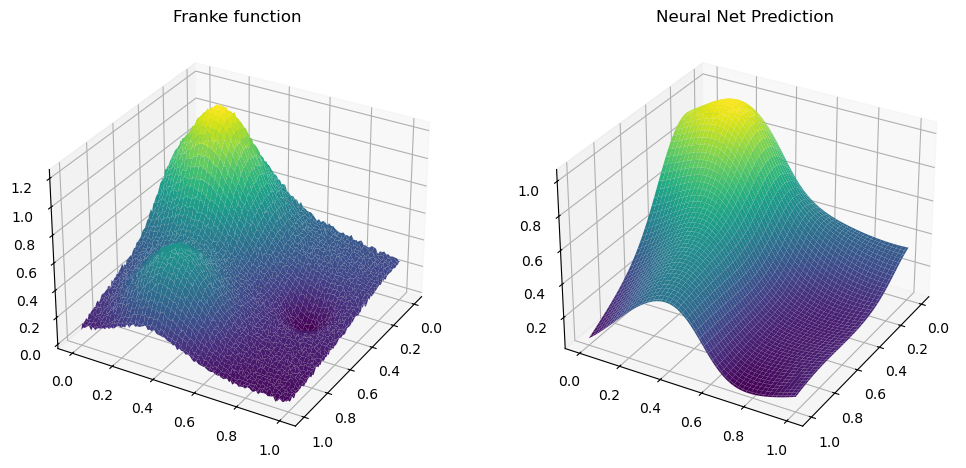

In [15]:
# Reshaping for plotting
x_plot = x.reshape((n,n))
y_plot = y.reshape((n,n))
z_plot = z_total.reshape((n,n))
z_orig_plot = z.reshape((n,n))

fig = plt.figure(figsize=(12, 6))

# Plotting the datapoints
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x_plot, y_plot, z_orig_plot, cmap='viridis', edgecolor='none')
ax.set_title('Franke function')
ax.view_init(azim=30)

# Plot the polynomial regression prediction 
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x_plot, y_plot, z_plot, cmap='viridis', edgecolor='none')
ax.set_title('Neural Net Prediction')
ax.view_init(azim=30)

plt.show()